In [54]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
if not "milligrad" in os.listdir():
    os.chdir('..')

from milligrad import Tensor, Adam
from extras.mnist import load_mnist_data

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

# flattening images and one-hot encoding labels
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]

# normalizing
mean, std = x_train.mean(), x_train.std()
x_train, x_test = (x_train - mean) / std, (x_test - mean) / std


In [56]:
class MLP:
    def __init__(self):
        super().__init__()
        self.w1 = Tensor.xavier(784, 128)
        self.b1 = Tensor.randn(128)
        self.w2 = Tensor.xavier(128, 10)
        self.b2 = Tensor.randn(10)
        
    def __call__(self, x:Tensor)->Tensor:
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2
    
    def parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]

# class Simple:
#     def __init__(self):
#         super().__init__()
#         self.w = Tensor.randn(784, 10)
#         self.b = Tensor.randn(10)
        
#     def __call__(self, x:Tensor)->Tensor:
#         return x @ self.w + self.b

In [57]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [58]:
EPOCHS = 10
BATCH_SIZE = 128
LR = 1e-3
LAMBDA = 1e-4


model = MLP()
optim = Adam(model.parameters(), lr=LR)

losses_epoch = []
accuracies_epoch = []

for _ in tqdm(range(EPOCHS)):
    shuffle = np.random.permutation(len(x_train))
    
    losses = []
    accuracies = []
    for i in range(0, len(x_train)//BATCH_SIZE):
        indices = shuffle[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        x = Tensor(x_train[indices])
        y = Tensor(y_train[indices])
        y_hat = model(x)
        
        # This is simply the cross-entropy loss
        loss = -(y * y_hat.log_softmax()).sum(axis=-1).mean()
        loss += LAMBDA * ((model.w1**2).sum().sum() + (model.w2**2).sum().sum())

        losses.append(loss.data)
        accuracies.append(accuracy(y.data, y_hat.data))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    losses_epoch.append(np.mean(losses))
    accuracies_epoch.append(np.mean(accuracies))
            

100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


In [59]:
from milligrad import topological_sort
[x._grad_fn for x in reversed(topological_sort(loss)) if x._grad_fn]

['+',
 '-',
 'mean',
 'sum',
 '*',
 'log_softmax',
 '+',
 '@',
 'relu',
 '+',
 '@',
 '*',
 '+',
 'sum',
 'sum',
 '**2',
 'sum',
 'sum',
 '**2']

Here we see that the regularization comes last in the backpropagation order even thought it was the last operation done on the loss Tensor, as should be expected.

In [60]:
model.w1.data.mean(), model.w2.data.mean(), model.w1.data.std(), model.w2.data.std()

(7.464157935733715e-05,
 4.4083441384042696e-05,
 0.00531465652229313,
 0.045626518212852546)

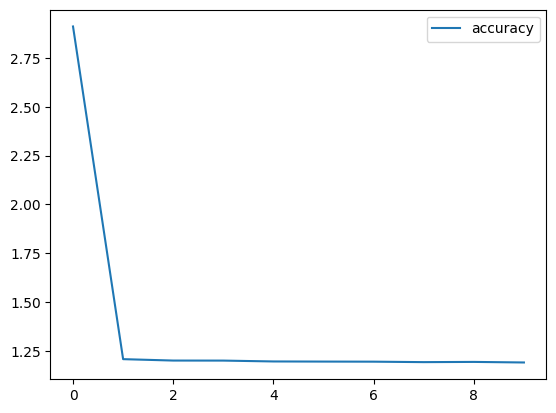

In [61]:
# plt.plot(losses_epoch, label='loss')
plt.plot(losses_epoch, label='accuracy')
plt.legend()
plt.show()

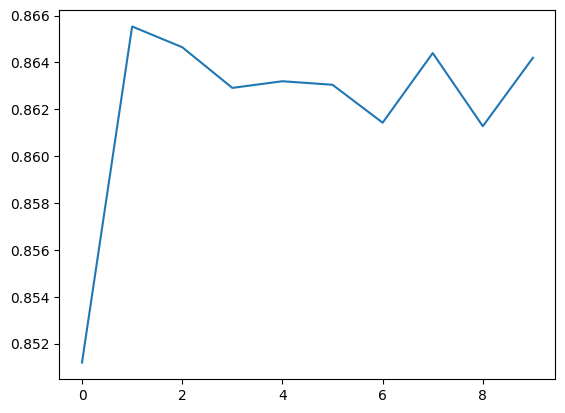

In [62]:
plt.plot(accuracies_epoch)

In [63]:
accuracy(y_test, model(Tensor(x_test)).data)

0.8631

4


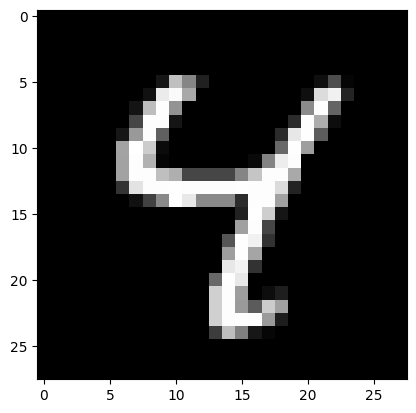

In [64]:
idx = 6

print(model(Tensor(x_test[idx])).data.argmax())

plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')